In [1]:
using Flux, Solaris, OrdinaryDiffEq, Plots, Solaris.DiffEqFlux

In [163]:
# right-hand side of differential equation
f(y, t) = -exp(-t)# * y
f(y, p, t) = -exp(-t)# * y # parameterized equation for DifferentialEquations.jl

f (generic function with 2 methods)

In [164]:
# computational parameters
h = 0.05 # time step

0.05

In [165]:
X = randn(1, 1000)
T = rand(1, 1000) * 50
Y = zeros(1, 1000)

for i in axes(X, 2)
    u0 = X[1, i]
    tspan = (T[1, i], T[1, i] + h)
    prob = ODEProblem(f, u0, tspan)
    sol = solve(prob, BS3(), dt = h, adaptive=false)
    Y[1, i] = sol.u[end]
end

In [166]:
# p[1:3]: a21, a31, a32
# p[4:6]: b
# p[7:9]: c

p = zeros(Float32, 9)

9-element Vector{Float32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [167]:
# our neural RK model
# it's nothing but just parameter flows
function model(p)
    k1 = @. f(X, T)
    k2 = @. f(X + h * p[1] * k1, T + p[8] * h)
    k3 = @. f(X + h * (p[2] * k1 + p[3] * k2), T + p[9] * h)
    
    return @. X + h * (p[4] * k1 + p[5] * k2 + p[6] * k3)
end

function loss(p)
    Y1 = model(p)
    return sum((Y .- Y1).^2) + (sum(p[4:6]) - 1.0)^2 + (p[1] - p[8])^2 + (p[2] + p[3] - p[9])^2
end

loss (generic function with 1 method)

In [168]:
cb = function (p, l)
    display(l)
    return false
end

#31 (generic function with 1 method)

In [169]:
res = sci_train(loss, p, LBFGS(), cb = cb, maxiters = 500)

1.038870947666701

2.3730467923826346e-5

2.372995150753947e-5

2.372530427779687e-5

2.1381056008722672e-6

1.5682818415079809e-9

1.9959578451474907e-14

9.710046073157304e-21

u: 9-element Vector{Float32}:
 0.64443016
 0.42962018
 0.42962018
 0.33329505
 0.33335027
 0.33335477
 0.0
 0.64443016
 0.85924035

In [170]:
res.u

9-element Vector{Float32}:
 0.64443016
 0.42962018
 0.42962018
 0.33329505
 0.33335027
 0.33335477
 0.0
 0.64443016
 0.85924035

In [162]:
res.u

9-element Vector{Float32}:
 0.6415251
 0.42768365
 0.4276829
 0.3332867
 0.33334693
 0.33336627
 0.0
 0.6415251
 0.8553666

## Test the trained model

In [171]:
f1(y, t) = -exp(-t)

f1 (generic function with 1 method)

In [172]:
function predict(x, t, h, p)
    k1 = f(x, t)
    k2 = f(x + h * p[1] * k1, t + p[8] * h)
    k3 = f(x + h * (p[2] * k1 + p[3] * k2), t + p[9] * h)
    
    return @. x + h * (p[4] * k1 + p[5] * k2 + p[6] * k3)
end

predict (generic function with 1 method)

In [173]:
u = zeros(50); u[1] = 1.0
t = zeros(50); t[1] = 0.0
for i = 2:length(u)
    t[i] = t[i-1] + h
    u[i] = predict(u[i-1], t[i-1], h, res.u)
end

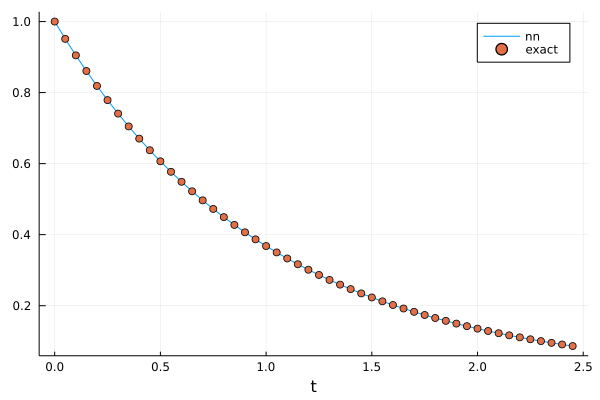

In [174]:
plot(t, u, label="nn", xlabel="t")
scatter!(t, exp.(-t), label="exact")